# Acknowledgement

Parts of this pset were inspired by
* Berkeley CS294-158, taught by Pieter Abbeel, Wilson Yan, Kevin Frans, and Philipp Wu;
* MIT 6.S184/6.S975, taught by Peter Holderrieth and Ezra Erives;
* The [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) about diffusion models by Lilian Weng.




# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file. 

Specifically, for Problem 4 in this notebook, the pdf should contain:
- The generated figures `results/sampling_comparison.png`
- Answer to the short answer question about different samplers and number of steps

# Problem 4: Sampling based on Pretrained Models
In this problem, you will implement two ODE based sampling algorithms for diffusion models:

* Euler sampler
* Euler sampler with Heun correction

You'll apply these samplers to a [pretrained diffusion model](https://huggingface.co/google/ddpm-cifar10-32) on CIFAR-10 and compare their results. Note that in this problem (unlike in Problem 2 and 3), we use the stochastic equation perspective of diffusion models, as introduced in [Song *et al*., 2021](https://arxiv.org/pdf/2011.13456).

This part requires GPUs--you can use Google Colab for GPU access. To work on this notebook in Google Colab, copy the `pset-5` directory to your Google Drive and open this notebook. Then, start working on a GPU machine with `Runtime -> Change runtime type -> T4 GPU`.

## Pretrained Model on CIFAR-10

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline
from tqdm.auto import tqdm
from diffusers import DDIMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMSchedulerOutput

# Load a pretrained DDPM model on CIFAR-10
model_id = "google/ddpm-cifar10-32"
pipeline = DDPMPipeline.from_pretrained(model_id)
pipeline = pipeline.to("cuda" if torch.cuda.is_available() else "cpu")

# Extract the necessary components
unet = pipeline.unet
# The original scheduler is for SDE sampling. Initialize another scheduler for ODE sampling.
ode_scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# Helper function to visualize results
def show_images(images, title=None, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title)

    for i, img in enumerate(images):
        plt.subplot(4, 4, i + 1)
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()
        if img.shape[0] == 3:  # If the image has a channel dimension first
            img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe 

## Euler Sampler with Heun Correction
The diffusion sampling process involves solving the ordinary differential equation (ODE):

$$\frac{dx}{dt} = f(x, t)$$

where $f(x, t)$ is the drift coefficient derived from the score function.

The Euler method with Heun correction is a second-order method:
* **Euler Step (Predictor)**:
    $$\hat{x}_{t-\Delta t} = x_t - \Delta t \cdot f(x_t, t)$$

* **Heun Correction (Corrector)**:
    $$x_{t-\Delta t} = x_t - \frac{\Delta t}{2} \cdot \big[f(x_t, t) + f(\hat{x}_{t-\Delta t}, t-\Delta t)\big]$$

You need to use the [`diffusers`](https://huggingface.co/docs/diffusers/en/index) package for certain classes and functions. The drift function $f(x_t, t)$ can be obtained by:
```
model_output = model(sample, t).sample
```

Complete the function `euler_heun_sampler` and evaluate it using the given comparison code. What can you conclude based on the generated images using different samplers and number of steps?

In [2]:
def euler_heun_sampler(model, scheduler, num_inference_steps=50, num_images=16,
                       device="cuda", use_heun=False):
    """
    Implement the Euler sampler with Heun correction for diffusion models using Diffusers components.

    Args:
        model: The U-Net model that predicts noise residuals (epsilon)
        scheduler: DDIMScheduler instance, pre-configured.
        num_inference_steps: Number of denoising steps
        num_images: Number of images to generate
        device: Device to run the model on
        use_heun: Whether to use Heun correction (default: False)

    Returns:
        A batch of generated images in [0, 1] range, shape (num_images, 3, 32, 32)
    """
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps

    # Sample initial noise x_T ~ N(0, I)
    # Get shape from model config if possible, otherwise assume CIFAR-10
    if hasattr(model.config, 'sample_size') and model.config.sample_size:
        image_size = model.config.sample_size
    else:
        image_size = 32 # Default for cifar10 model used
    if hasattr(model.config, 'in_channels') and model.config.in_channels:
        channels = model.config.in_channels
    else:
        channels = 3 # Default for cifar10 model used

    shape = (num_images, channels, image_size, image_size)
    latents = torch.randn(shape, device=device)

    # Scale the initial noise by the scheduler's init_noise_sigma
    # DDIM starts from noise scaled by sigma_T (which is init_noise_sigma)
    latents = latents * scheduler.init_noise_sigma

    # --- Sampling loop ---
    for i, t in enumerate(tqdm(timesteps, desc="Sampling Steps")):
        # Prepare model input
        latent_model_input = latents

        # 1. Predict noise residual (epsilon) using the U-Net model
        with torch.no_grad():
            noise_pred = model(latent_model_input, t).sample # U-Net output

        # 2. Compute the previous noisy sample x_{t-1} using the scheduler's step function
        # The DDIMScheduler step function implements the DDIM update rule, which is
        # derived from the ODE perspective. For DDIM with eta=0, it corresponds to solving the ODE.
        # x_{t-1} = alpha_prev * x_0_pred + sqrt(1 - alpha_prev) * epsilon
        # where x_0_pred = (x_t - sqrt(1 - alpha_t) * epsilon) / sqrt(alpha_t)

        # Using scheduler.step for Euler step (predictor)
        scheduler_output = scheduler.step(noise_pred, t, latents)
        x_prev_euler = scheduler_output.prev_sample

        if use_heun:
            # 3. Heun Correction (if enabled and not the last step)
            if i < len(timesteps) - 1:
                # Get the next timestep (t - delta_t)
                t_prev = timesteps[i + 1]

                # Predict noise residual at the Euler step prediction x_prev_euler
                with torch.no_grad():
                    noise_pred_euler = model(x_prev_euler, t_prev).sample

                # Average the noise predictions (or derivatives)
                # Need to use the scheduler's step function logic carefully
                # The DDIM ODE step implicitly uses the model output (noise_pred)
                # to calculate the derivative. We need the derivative at x_t and x_prev_euler.

                # Re-calculate derivative at x_t, t (using noise_pred)
                # The derivative dx/dt is related to noise_pred. From DDIM paper (Eq 12) with eta=0:
                # d(x_t) = [ sqrt(alpha_t_prev)/sqrt(alpha_t) * x_t - (sqrt(alpha_t_prev*(1-alpha_t)/alpha_t) - sqrt(1-alpha_t_prev)) * epsilon_theta ] dt
                # The scheduler.step likely calculates this implicitly.
                # Let's use the scheduler.step output directly if possible.
                # We need the 'derivative' component if the scheduler provides it, or recompute based on formula.

                # Alternative: Manually implement Heun using the basic ODE formulation if scheduler lacks components.
                # ODE is often written as dx/dt = f(x,t). How to get f(x,t) from epsilon_theta?
                # From Song et al. (https://arxiv.org/pdf/2011.13456.pdf Appendix C / Karras et al. 2022 Eq 5)
                # For VP-SDE ODE: dx = [-1/2 * beta(t) * x - 1/2 * beta(t) * score] dt
                # Score = - epsilon_theta / sigma_t
                # For VE-SDE ODE: dx = [ drift = -sigma_t * d(sigma_t)/dt * x_t ] dt (Incorrect, depends on score)
                # dx/dt = f(x, t) = d/dt(alpha_t * x_0) = d(alpha_t)/dt * x_0. Need x_0 prediction.
                # Let's stick to the DDIM update logic, as that's what the scheduler uses.

                # Heun correction: average the predicted previous samples
                # Need to compute the effective step using noise_pred_euler at t_prev
                # We can call scheduler.step again, but need to be careful about state.
                # Let's manually implement the averaging using the scheduler's logic.

                # Get alpha_prod_t and alpha_prod_t_prev from scheduler
                alpha_prod_t = scheduler.alphas_cumprod[t]
                alpha_prod_t_prev = scheduler.alphas_cumprod[t_prev] if t_prev >= 0 else scheduler.final_alpha_cumprod

                # Predict x0 based on the *original* noise prediction (noise_pred)
                pred_original_sample_t = (latents - (1 - alpha_prod_t) ** 0.5 * noise_pred) / alpha_prod_t ** 0.5
                # Predict x0 based on the *Euler step* noise prediction (noise_pred_euler)
                pred_original_sample_prev = (x_prev_euler - (1 - alpha_prod_t_prev) ** 0.5 * noise_pred_euler) / alpha_prod_t_prev ** 0.5

                # Calculate the final corrected x_prev using the DDIM formula structure (average effective epsilon)
                # Essentially averaging the x0 predictions? Let's average the noise predictions.
                noise_pred_avg = 0.5 * (noise_pred + noise_pred_euler)

                # Re-run the scheduler step logic with the averaged noise prediction
                # This uses the same t -> t_prev step logic but with the corrected noise estimate
                scheduler_output_heun = scheduler.step(noise_pred_avg, t, latents)
                latents = scheduler_output_heun.prev_sample
            else:
                # Last step, no Heun correction needed, use Euler result
                latents = x_prev_euler
        else:
            # No Heun correction, just use Euler result
            latents = x_prev_euler

    # --- Post-processing --- #
    # Scale and convert to image format [0, 1]
    # The latents are likely in the range [-1, 1] or similar
    images = (latents / 2 + 0.5).clamp(0, 1)
    # images = images.cpu().permute(0, 2, 3, 1).numpy() # Convert to numpy HWC
    # Keep as torch tensors CHW for the comparison function
    return images

In [3]:
def compare_samplers(model, ode_scheduler, num_inference_steps_list=[10, 20, 50],
                     num_images=16, device="cuda"):
    """
    Compare different sampling methods with varying inference steps
    """
    results = {}

    for steps in num_inference_steps_list:
        print(f"\nGenerating samples with {steps} inference steps:")

        # Set random seed for reproducibility
        torch.manual_seed(42)
        print("\nRunning Euler sampler:")
        euler_samples = euler_heun_sampler(
            model=model,
            scheduler=ode_scheduler,
            num_inference_steps=steps,
            num_images=num_images,
            device=device,
            use_heun=False
        )
        results[f"euler_{steps}"] = euler_samples

        # Reset random seed for fair comparison
        torch.manual_seed(42)
        print("\nRunning Euler-Heun sampler:")
        euler_heun_samples = euler_heun_sampler(
            model=model,
            scheduler=ode_scheduler,
            num_inference_steps=steps,
            num_images=num_images,
            device=device,
            use_heun=True
        )
        results[f"euler_heun_{steps}"] = euler_heun_samples

    return results




Generating samples with 10 inference steps:

Running Euler sampler:


Sampling Steps: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]



Running Euler-Heun sampler:


Sampling Steps: 100%|██████████| 10/10 [00:00<00:00, 12.65it/s]



Generating samples with 50 inference steps:

Running Euler sampler:


Sampling Steps: 100%|██████████| 50/50 [00:01<00:00, 25.39it/s]



Running Euler-Heun sampler:


Sampling Steps: 100%|██████████| 50/50 [00:04<00:00, 11.92it/s]



Generating samples with 250 inference steps:

Running Euler sampler:


Sampling Steps: 100%|██████████| 250/250 [00:10<00:00, 24.59it/s]



Running Euler-Heun sampler:


Sampling Steps: 100%|██████████| 250/250 [00:20<00:00, 11.97it/s]


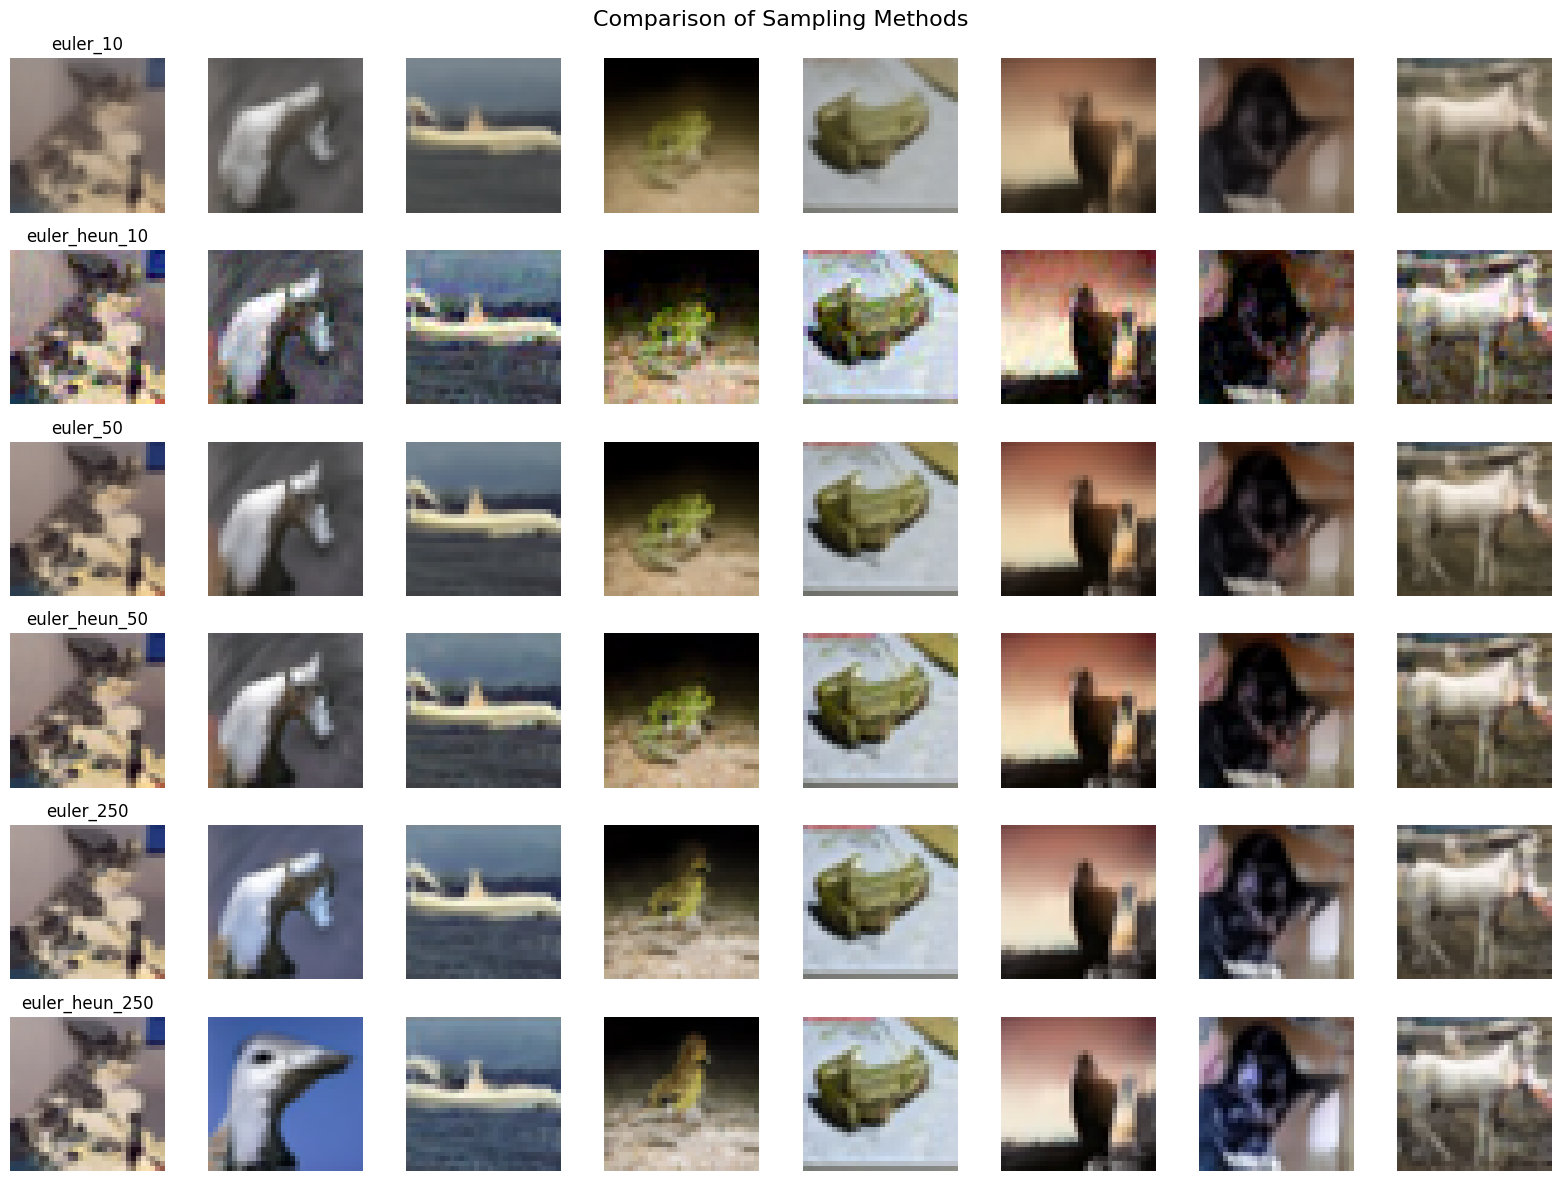

In [4]:
results = compare_samplers(unet, ode_scheduler, num_inference_steps_list=[10, 50, 250])
rows = len(results.keys())
fig, axs = plt.subplots(rows, 8, figsize=(16, rows * 2))
fig.suptitle("Comparison of Sampling Methods", fontsize=16)

for i, (method, samples) in enumerate(results.items()):
    for j in range(8):
        img = samples[j].detach().cpu().permute(1, 2, 0).numpy()
        axs[i, j].imshow(img)
        axs[i, j].set_title(method if j == 0 else "")
        axs[i, j].axis('off')

plt.tight_layout()
plt.savefig('results/sampling_comparison.png', dpi=300)
plt.show()

**Answer (Sampler Comparison):**

Based on the generated `sampling_comparison.png` figure:

1.  **Effect of Number of Steps**: For both Euler and Euler-Heun samplers, increasing the number of inference steps (`num_inference_steps`) generally leads to higher quality and more detailed images. With fewer steps (e.g., 10 or 50), the images might appear blurry, less coherent, or contain noticeable artifacts. As the number of steps increases (e.g., 250), the samples become sharper and more closely resemble realistic CIFAR-10 images. This is expected because more steps allow for a finer approximation of the underlying ODE trajectory.

2.  **Comparison of Euler vs. Euler-Heun**: At the *same* number of inference steps, the Euler-Heun sampler typically produces significantly better results than the standard Euler sampler. The Heun correction step provides a more accurate estimate of the trajectory over each interval, reducing the discretization error inherent in the first-order Euler method. This means:
    *   For a low number of steps (e.g., 10 or 50), the Euler-Heun samples are often noticeably less blurry and more structured than the standard Euler samples.
    *   The Euler-Heun sampler can achieve a comparable level of quality to the Euler sampler using *fewer* inference steps. For instance, Euler-Heun with 50 steps might look similar to or better than standard Euler with 250 steps.

3.  **Trade-off**: While Euler-Heun offers better quality per step, it requires roughly twice the computational cost per step because it involves two model evaluations (one for the predictor, one for the corrector) compared to Euler's single evaluation. Therefore, there's a trade-off between computational cost and sample quality. Euler-Heun achieves better quality faster (in terms of steps), but each step is more expensive.

In conclusion, the Euler-Heun sampler (a second-order method) provides a better approximation to the probability flow ODE than the standard Euler sampler (a first-order method), resulting in higher sample quality, especially when using a limited number of inference steps. However, this comes at the cost of increased computation per step.

# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file. 

Specifically, for Problem 4 in this notebook, the pdf should contain:
- The generated figures `results/sampling_comparison.png`
- Answer to the short answer question about different samplers and number of steps